# Reinforcement Learning

This IPy notebook acts as supporting material for **Chapter 21 Reinforcement Learning** of the book* Artificial Intelligence: A Modern Approach*. This notebook makes use of the implementations in rl.py module. We also make use of implementation of MDPs in the mdp.py module to test our agents. It might be helpful if you have already gone through the IPy notebook dealing with Markov decision process. Let us import everything from the rl module. It might be helpful to view the source of some of our implementations. Please refer to the Introductory IPy file for more details.

In [1]:
from rl import *

## Review
Before we start playing with the actual implementations let us review a couple of things about RL.

1. Reinforcement Learning is concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. 

2. Reinforcement learning differs from standard supervised learning in that correct input/output pairs are never presented, nor sub-optimal actions explicitly corrected. Further, there is a focus on on-line performance, which involves finding a balance between exploration (of uncharted territory) and exploitation (of current knowledge).

-- Source: [Wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)

In summary we have a sequence of state action transitions with rewards associated with some states. Our goal is to find the optimal policy (pi) which tells us what action to take in each state.

## Passive Reinforcement Learning

In passive Reinforcement Learning the agent follows a fixed policy and tries to learn the Reward function and the Transition model (if it is not aware of that).



### Passive Temporal Difference Agent

The PassiveTDAgent class in the rl module implements the Agent Program (notice the usage of word Program) described in **Fig 21.4** of the AIMA Book. PassiveTDAgent uses temporal differences to learn utility estimates. In simple terms we learn the difference between the states and backup the values to previous states while following a fixed policy.  Let us look into the source before we see some usage examples.

In [2]:
%psource PassiveTDAgent

The Agent Program can be obtained by creating the instance of the class by passing the appropriate parameters. Because of the __ call __ method the object that is created behaves like a callable and returns an appropriate action as most Agent Programs do. To instantiate the object we need a policy(pi) and a mdp whose utility of states will be estimated. Let us import a GridMDP object from the mdp module. **Figure 17.1 (sequential_decision_environment)** is similar to **Figure 21.1** but has some discounting as **gamma = 0.9**.

In [3]:
from mdp import sequential_decision_environment

**Figure 17.1 (sequential_decision_environment)** is a GridMDP object and is similar to the grid shown in **Figure 21.1**. The rewards in the terminal states are **+1** and **-1** and **-0.04** in rest of the states. <img src="files/images/mdp.png"> Now we define a policy similar to **Fig 21.1** in the book.

In [4]:
# Action Directions
north = (0, 1)
south = (0,-1)
west = (-1, 0)
east = (1, 0)

policy = {
    (0, 2): east,  (1, 2): east,  (2, 2): east,   (3, 2): None,
    (0, 1): north,                (2, 1): north,  (3, 1): None,
    (0, 0): north, (1, 0): west,  (2, 0): west,   (3, 0): west, 
}


Let us create our object now. We also use the **same alpha** as given in the footnote of the book on **page 837**.

In [5]:
our_agent = PassiveTDAgent(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))

The rl module also has a simple implementation to simulate iterations. The function is called **run_single_trial**. Now we can try our implementation. We can also compare the utility estimates learned by our agent to those obtained via **value iteration**.


In [6]:
from mdp import value_iteration

The values calculated by value iteration:

In [7]:
print(value_iteration(sequential_decision_environment))

{(0, 1): 0.3984432178350045, (1, 2): 0.649585681261095, (3, 2): 1.0, (0, 0): 0.2962883154554812, (3, 0): 0.12987274656746342, (3, 1): -1.0, (2, 1): 0.48644001739269643, (2, 0): 0.3447542300124158, (2, 2): 0.7953620878466678, (1, 0): 0.25386699846479516, (0, 2): 0.5093943765842497}


Now the values estimated by our agent after **200 trials**.

In [8]:
for i in range(200):
    run_single_trial(our_agent,sequential_decision_environment)
print(our_agent.U)

{(0, 1): 0.3892840731173828, (1, 2): 0.6211579621949068, (3, 2): 1, (0, 0): 0.3022330060485855, (2, 0): 0.0, (3, 0): 0.0, (1, 0): 0.18020445259687815, (3, 1): -1, (2, 2): 0.822969605478094, (2, 1): -0.8456690895152308, (0, 2): 0.49454878907979766}


We can also explore how these estimates vary with time by using plots similar to **Fig 21.5a**. To do so we define a function to help us with the same. We will first enable matplotlib using the inline backend.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def graph_utility_estimates(agent_program, mdp, no_of_iterations, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    for iteration in range(1,no_of_iterations+1):
        run_single_trial(agent_program, mdp)
        for state in states_to_graph:
            graphs[state].append((iteration, agent_program.U[state]))
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    plt.ylim([0,1.2])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

Here is a plot of state (2,2).

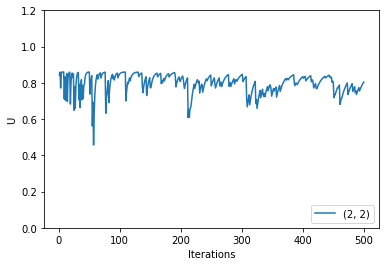

In [10]:
agent = PassiveTDAgent(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])

It is also possible to plot multiple states on the same plot.

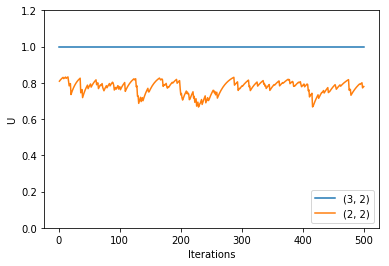

In [11]:
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2), (3,2)])

## Active Reinforcement Learning

Unlike Passive Reinforcement Learning in Active Reinforcement Learning we are not bound by a policy pi and we need to select our actions. In other words the agent needs to learn an optimal policy. The fundamental tradeoff the agent needs to face is that of exploration vs. exploitation. 

### QLearning Agent

The QLearningAgent class in the rl module implements the Agent Program described in **Fig 21.8** of the AIMA Book. In Q-Learning the agent learns an action-value function Q which gives the utility of taking a given action in a particular state. Q-Learning does not required a transition model and hence is a model free method. Let us look into the source before we see some usage examples.

In [12]:
%psource QLearningAgent

The Agent Program can be obtained by creating the instance of the class by passing the appropriate parameters. Because of the __ call __ method the object that is created behaves like a callable and returns an appropriate action as most Agent Programs do. To instantiate the object we need a mdp similar to the PassiveTDAgent.

 Let us use the same GridMDP object we used above. **Figure 17.1 (sequential_decision_environment)** is similar to **Figure 21.1** but has some discounting as **gamma = 0.9**. The class also implements an exploration function **f** which returns fixed **Rplus** untill agent has visited state, action **Ne** number of times. This is the same as the one defined on page **842** of the book. The method **actions_in_state** returns actions possible in given state. It is useful when applying max and argmax operations.

Let us create our object now. We also use the **same alpha** as given in the footnote of the book on **page 837**. We use **Rplus = 2** and **Ne = 5** as defined on page 843. **Fig 21.7**  

In [13]:
q_agent = QLearningAgent(sequential_decision_environment, Ne=5, Rplus=2, 
                         alpha=lambda n: 60./(59+n))

Now to try out the q_agent we make use of the **run_single_trial** function in rl.py (which was also used above). Let us use **200** iterations.

In [14]:
for i in range(200):
    run_single_trial(q_agent,sequential_decision_environment)

Now let us see the Q Values. The keys are state-action pairs. Where differnt actions correspond according to:

north = (0, 1)
south = (0,-1)
west = (-1, 0)
east = (1, 0)

In [15]:
q_agent.Q

defaultdict(float,
            {((0, 0), (-1, 0)): -0.12953971401732597,
             ((0, 0), (0, -1)): -0.12753699595470713,
             ((0, 0), (0, 1)): -0.01158029172666495,
             ((0, 0), (1, 0)): -0.13035841083471436,
             ((0, 1), (-1, 0)): -0.04,
             ((0, 1), (0, -1)): -0.1057916516323444,
             ((0, 1), (0, 1)): 0.13072636267769677,
             ((0, 1), (1, 0)): -0.07323076923076924,
             ((0, 2), (-1, 0)): 0.12165200587479848,
             ((0, 2), (0, -1)): 0.09431411803674361,
             ((0, 2), (0, 1)): 0.14047883620608154,
             ((0, 2), (1, 0)): 0.19224095989491635,
             ((1, 0), (-1, 0)): -0.09696833851887868,
             ((1, 0), (0, -1)): -0.15641263417341367,
             ((1, 0), (0, 1)): -0.15340385689815017,
             ((1, 0), (1, 0)): -0.15224266498911238,
             ((1, 2), (-1, 0)): 0.18537063683043895,
             ((1, 2), (0, -1)): 0.17757702529142774,
             ((1, 2), (0, 1)): 0.1756212

The Utility **U** of each state is related to **Q** by the following equation.

**U (s) = max <sub>a</sub> Q(s, a)**

Let us convert the Q Values above into U estimates.



In [16]:
U = defaultdict(lambda: -1000.) # Very Large Negative Value for Comparison see below.
for state_action, value in q_agent.Q.items():
    state, action = state_action
    if U[state] < value:
                U[state] = value

In [17]:
U

defaultdict(<function __main__.<lambda>>,
            {(0, 0): -0.01158029172666495,
             (0, 1): 0.13072636267769677,
             (0, 2): 0.19224095989491635,
             (1, 0): -0.09696833851887868,
             (1, 2): 0.27484289408254886,
             (2, 0): -0.028114098214323924,
             (2, 1): 0.2965645851500498,
             (2, 2): 0.34260576652777697,
             (3, 0): -0.16576962655130892,
             (3, 1): -0.6897322258069369,
             (3, 2): 0.388990723935834})

Let us finally compare these estimates to value_iteration results.

In [18]:
print(value_iteration(sequential_decision_environment))

{(0, 1): 0.3984432178350045, (1, 2): 0.649585681261095, (3, 2): 1.0, (0, 0): 0.2962883154554812, (3, 0): 0.12987274656746342, (3, 1): -1.0, (2, 1): 0.48644001739269643, (2, 0): 0.3447542300124158, (2, 2): 0.7953620878466678, (1, 0): 0.25386699846479516, (0, 2): 0.5093943765842497}
